In [1]:
!pip install bs4 matplotlib seaborn

  Using cached bs4-0.0.2-py2.py3-none-any.whl.metadata (411 bytes)
  Using cached beautifulsoup4-4.13.4-py3-none-any.whl.metadata (3.8 kB)
  Using cached soupsieve-2.7-py3-none-any.whl.metadata (4.6 kB)
Using cached bs4-0.0.2-py2.py3-none-any.whl (1.2 kB)
Using cached beautifulsoup4-4.13.4-py3-none-any.whl (187 kB)
Using cached soupsieve-2.7-py3-none-any.whl (36 kB)

   ------------- -------------------------- 1/3 [beautifulsoup4]
   ------------- -------------------------- 1/3 [beautifulsoup4]
   ---------------------------------------- 3/3 [bs4]



In [2]:
from tqdm.auto import tqdm
import requests
from bs4 import BeautifulSoup

c:\Users\belch\anaconda3\envs\llmpy312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# @title Busca No G1

term = 'flamengo' # @param {type:"string"}
from urllib.parse import urlparse, parse_qs


def get_final_url(url):
    if url.startswith('//'):
        url = 'https:' + url

    parsed_url = urlparse(url)
    query_params = parse_qs(parsed_url.query)
    if 'u' in query_params:
        return query_params['u'][0]
    return ''

def scrape_news_body(url):

    response = requests.get(url)
    html = response.content

    soup = BeautifulSoup(html, "html.parser")
    texts = soup.select("p.content-text__container")
    return ' '.join([text.get_text() for text in texts])


def scrape_post_titles(url):

    response = requests.get(url)
    html = response.content

    soup = BeautifulSoup(html, "html.parser")
    urls = soup.select("div.widget--info__text-container a")
    urls = [get_final_url(url['href']) for url in urls if url.has_attr('href')]
    final_urls = []
    for url in urls:
        if not 'video' in url and not 'globoplay.globo.com' in url:
            final_urls.append(url)
    return final_urls

search_url = f"https://g1.globo.com/busca/?q={term}"
pages_to_scrape = 5
search_urls = [search_url] + [f"{search_url}&page={i}" for i in range(2, pages_to_scrape + 1)]
search_urls

urls = []
for url in search_urls:
    urls.extend(scrape_post_titles(url))

texts = [scrape_news_body(url) for url in tqdm(urls)]

100%|██████████| 18/18 [00:07<00:00,  2.40it/s]


In [5]:
!pip install --quiet transformers[torch]

In [4]:
from transformers import pipeline

model = "marquesafonso/bertimbau-large-ner-selective"

ner_pipeline = pipeline("ner",
                        model=model,
                        tokenizer=model,
                         aggregation_strategy="simple")




Some weights of the model checkpoint at marquesafonso/bertimbau-large-ner-selective were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'crf.end_transitions', 'crf.start_transitions', 'crf.transitions']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0


In [5]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model)

In [6]:
def extract_entities(text, max_tokens=512):
    entities = []
    words = text.split()
    blocks = []
    for word in words:
        blocks.append(word)
        text_truncated = " ".join(blocks)
        tokens = tokenizer(text_truncated, return_tensors="pt", truncation=False)
        if tokens.input_ids.shape[1] >= max_tokens:
            blocks.pop()
            text_truncated = " ".join(blocks)
            entities.extend(ner_pipeline(text_truncated))
            blocks = [word]
    entities.extend(ner_pipeline(text_truncated))
    return entities

In [7]:
all_entities = []
for text in tqdm(texts):
    all_entities.extend(extract_entities(text))

100%|██████████| 18/18 [00:09<00:00,  1.91it/s]


In [8]:
results = [entity['word'] for entity in all_entities if entity['entity_group'] in ["PESSOA", "ORGANIZACAO"]]

In [9]:
from collections import Counter

print()

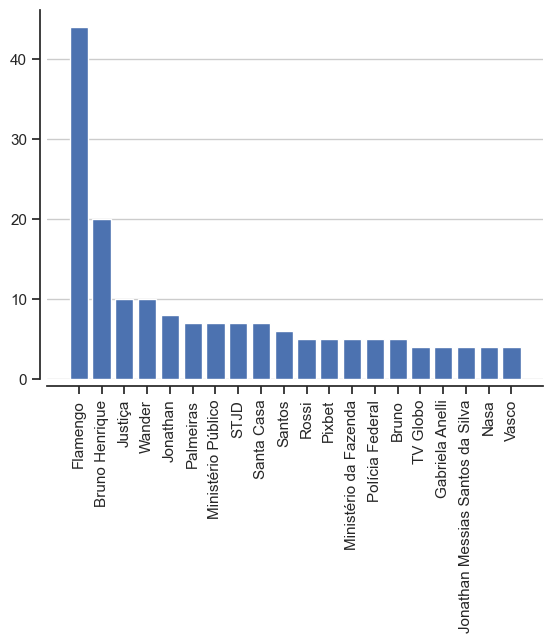

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="ticks")
top_10 = dict(Counter(results).most_common(20))
ax = plt.bar(top_10.keys(), top_10.values())
sns.despine(offset=5)
plt.grid(":", axis='y')
plt.xticks(rotation=90);


In [11]:
Counter(results).most_common()

[('Flamengo', 44),
 ('Bruno Henrique', 20),
 ('Justiça', 10),
 ('Wander', 10),
 ('Jonathan', 8),
 ('Palmeiras', 7),
 ('Ministério Público', 7),
 ('STJD', 7),
 ('Santa Casa', 7),
 ('Santos', 6),
 ('Rossi', 5),
 ('Pixbet', 5),
 ('Ministério da Fazenda', 5),
 ('Polícia Federal', 5),
 ('Bruno', 5),
 ('TV Globo', 4),
 ('Gabriela Anelli', 4),
 ('Jonathan Messias Santos da Silva', 4),
 ('Nasa', 4),
 ('Vasco', 4),
 ('Pixbet Soluções Tecnológicas Ltda', 4),
 ('PF', 4),
 ('Deat', 4),
 ('Carlo Ancelotti', 3),
 ('Ancelotti', 3),
 ('Gabriela', 3),
 ('MP', 3),
 ('Laysa', 3),
 ('Polícia Militar', 3),
 ('Wander Junior', 3),
 ('Caixa', 3),
 ('Carlos Alberto Braga Júnior', 3),
 ('Carlos', 3),
 ('Gabriella', 2),
 ('Promotoria', 2),
 ('Polícia Civil', 2),
 ('Helder Ribeiro', 2),
 ('RJ2', 2),
 ('Central Córdoba', 2),
 ('21ª DP', 2),
 ('Caixa Loterias S. A.', 2),
 ('Baú Bingo', 2),
 ('Tele Sena Bet', 2),
 ('Bet do Milhão', 2),
 ('Superior Tribunal de Justiça Desportiva', 2),
 ('Secretaria de Prêmios e Apost